## Table of Contents
* [1. Missingness analysis](#section_1)
    * [1.1. Load raw data](#section_1_1)
    * [1.2. Statistics about the indicator matrix](#section_1_2)
    * [1.3. Preprocess features](#section_1_3)
    * [1.4. Create indicator matrix](#section_1_4)
    * [1.5. Preprocess indicator matrix](#section_1_5)
    * [1.6. Information about the features](#section_1_6)
* [2. Matrices construction](#section_2)
    * [2.1. Correlation matrix](#section_2_1)
    * [2.2. Distance matrix](#section_2_2)
    * [2.3. Mutual information matrix](#section_2_3)
* [3. Comparison with degree distribution of randomized network](#section_3)
    * [3.1. Maximum Spanning Tree (MST): graph](#section_3_1)
    * [3.2. Planar Maximally Filtered Graph (PMFG): graph](#section_3_2)
    * [3.3. Disparity Filter (Backbone): graph](#section_3_3)
    * [3.4. Efficiency Cost Optimisation (ECO): graph](#section_3_4)
    * [3.5. Triangulated Maximally Filtered Graph (TMFG): Simplificial complex](#section_3_5)

In [155]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from backbone import disparity_filter, disparity_filter_alpha_cut
from ECO import eco
from PMFG import pmfg
from TMFG import tmfg
import missingno as msno
import pandas as pd
import networkx as nx
import numpy as np

## 1. Missingness analysis <a class="anchor" id="section_1"></a>

### 1.1. Load raw data <a class="anchor" id="section_1_1"></a>

In [156]:
# The raw_data have to convert into a dataframe then send in the  variable indicator_matrix_df for preprocessing
# After the preprocessing step the indicator_matrix_df will be convert into an array and a dictionary to save the feature names
raw_data = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/missingno-data/master/nyc_collision_factors.csv")
indicator_matrix_df = raw_data

### 1.2. Statistics about the indicator matrix <a class="anchor" id="section_1_6"></a> 

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLISTS INJURED', 'NUMBER OF CYCLISTS KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')


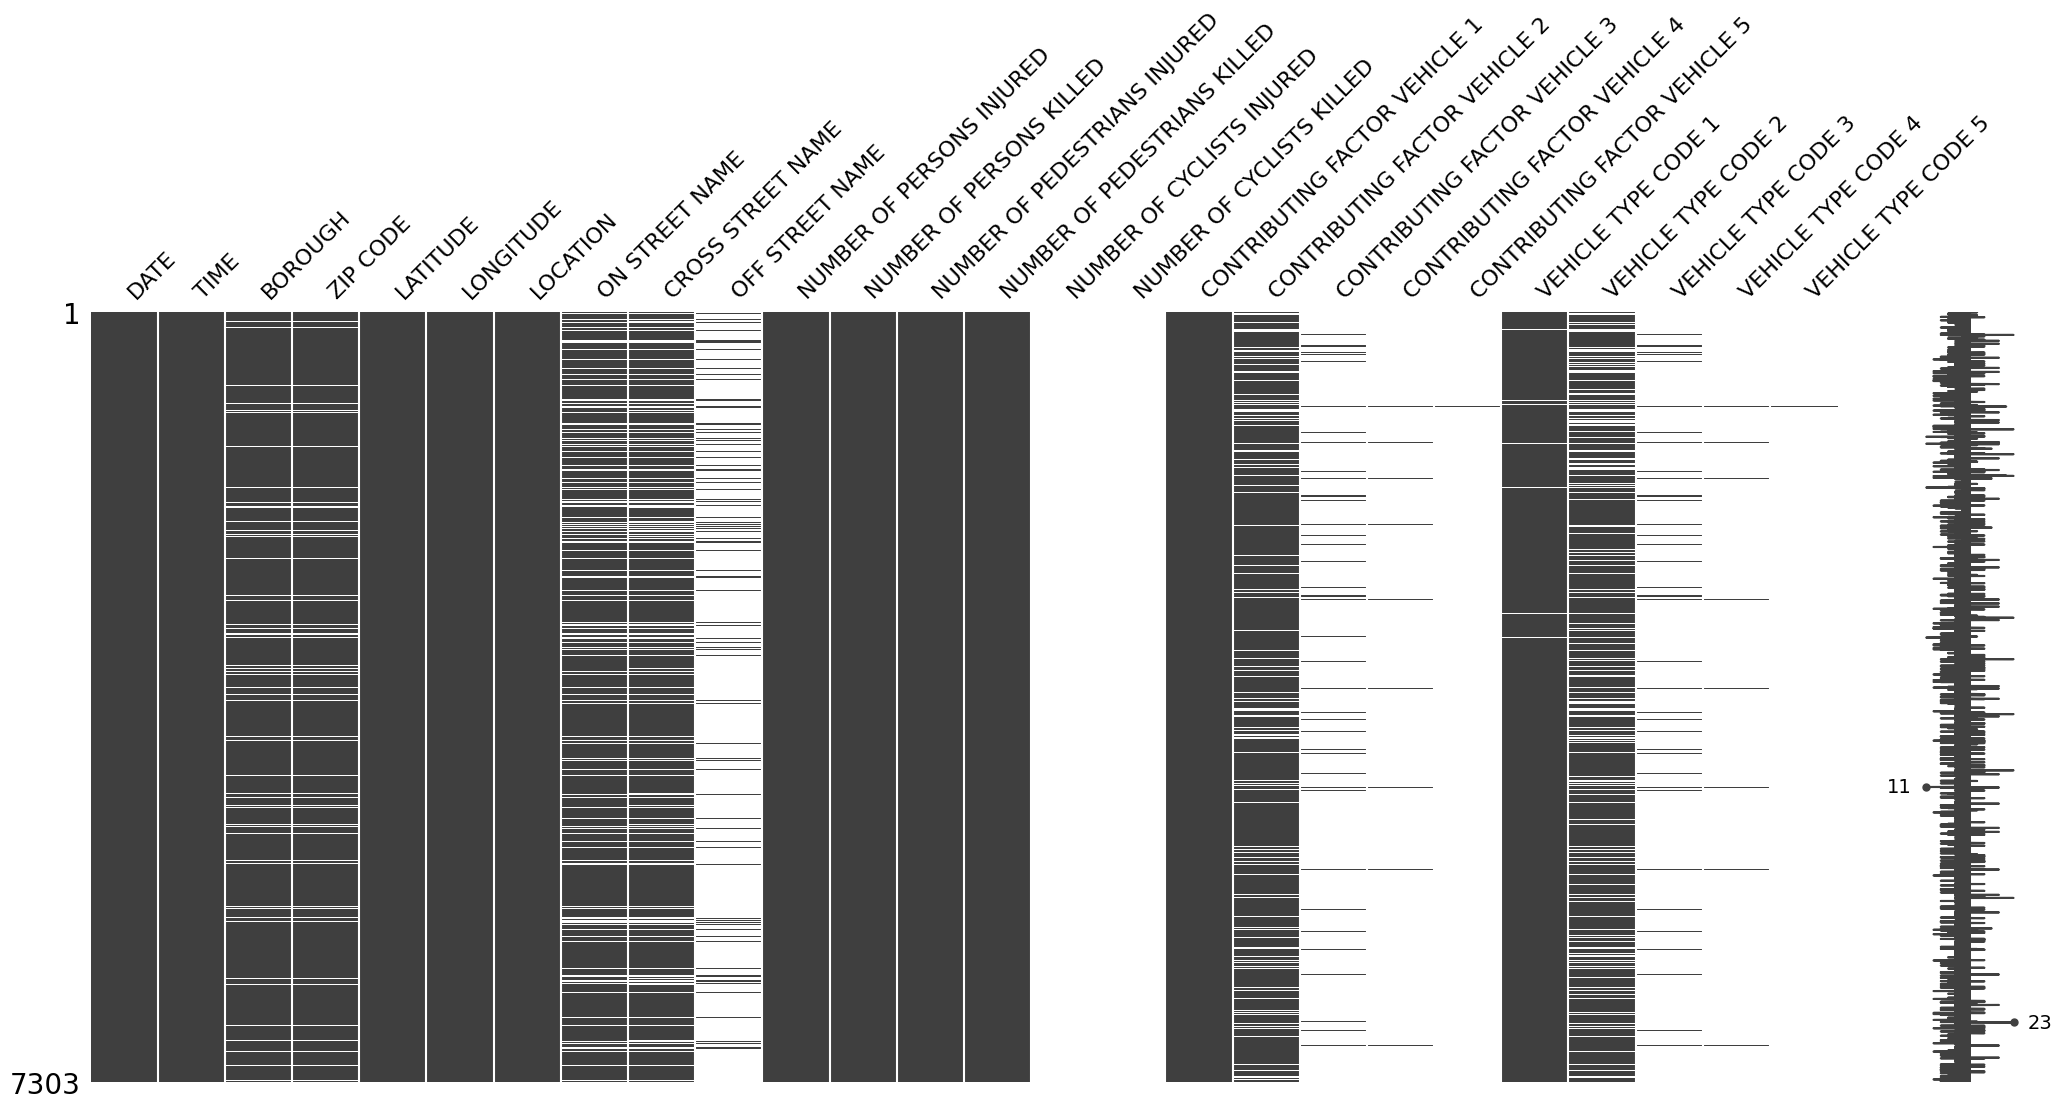

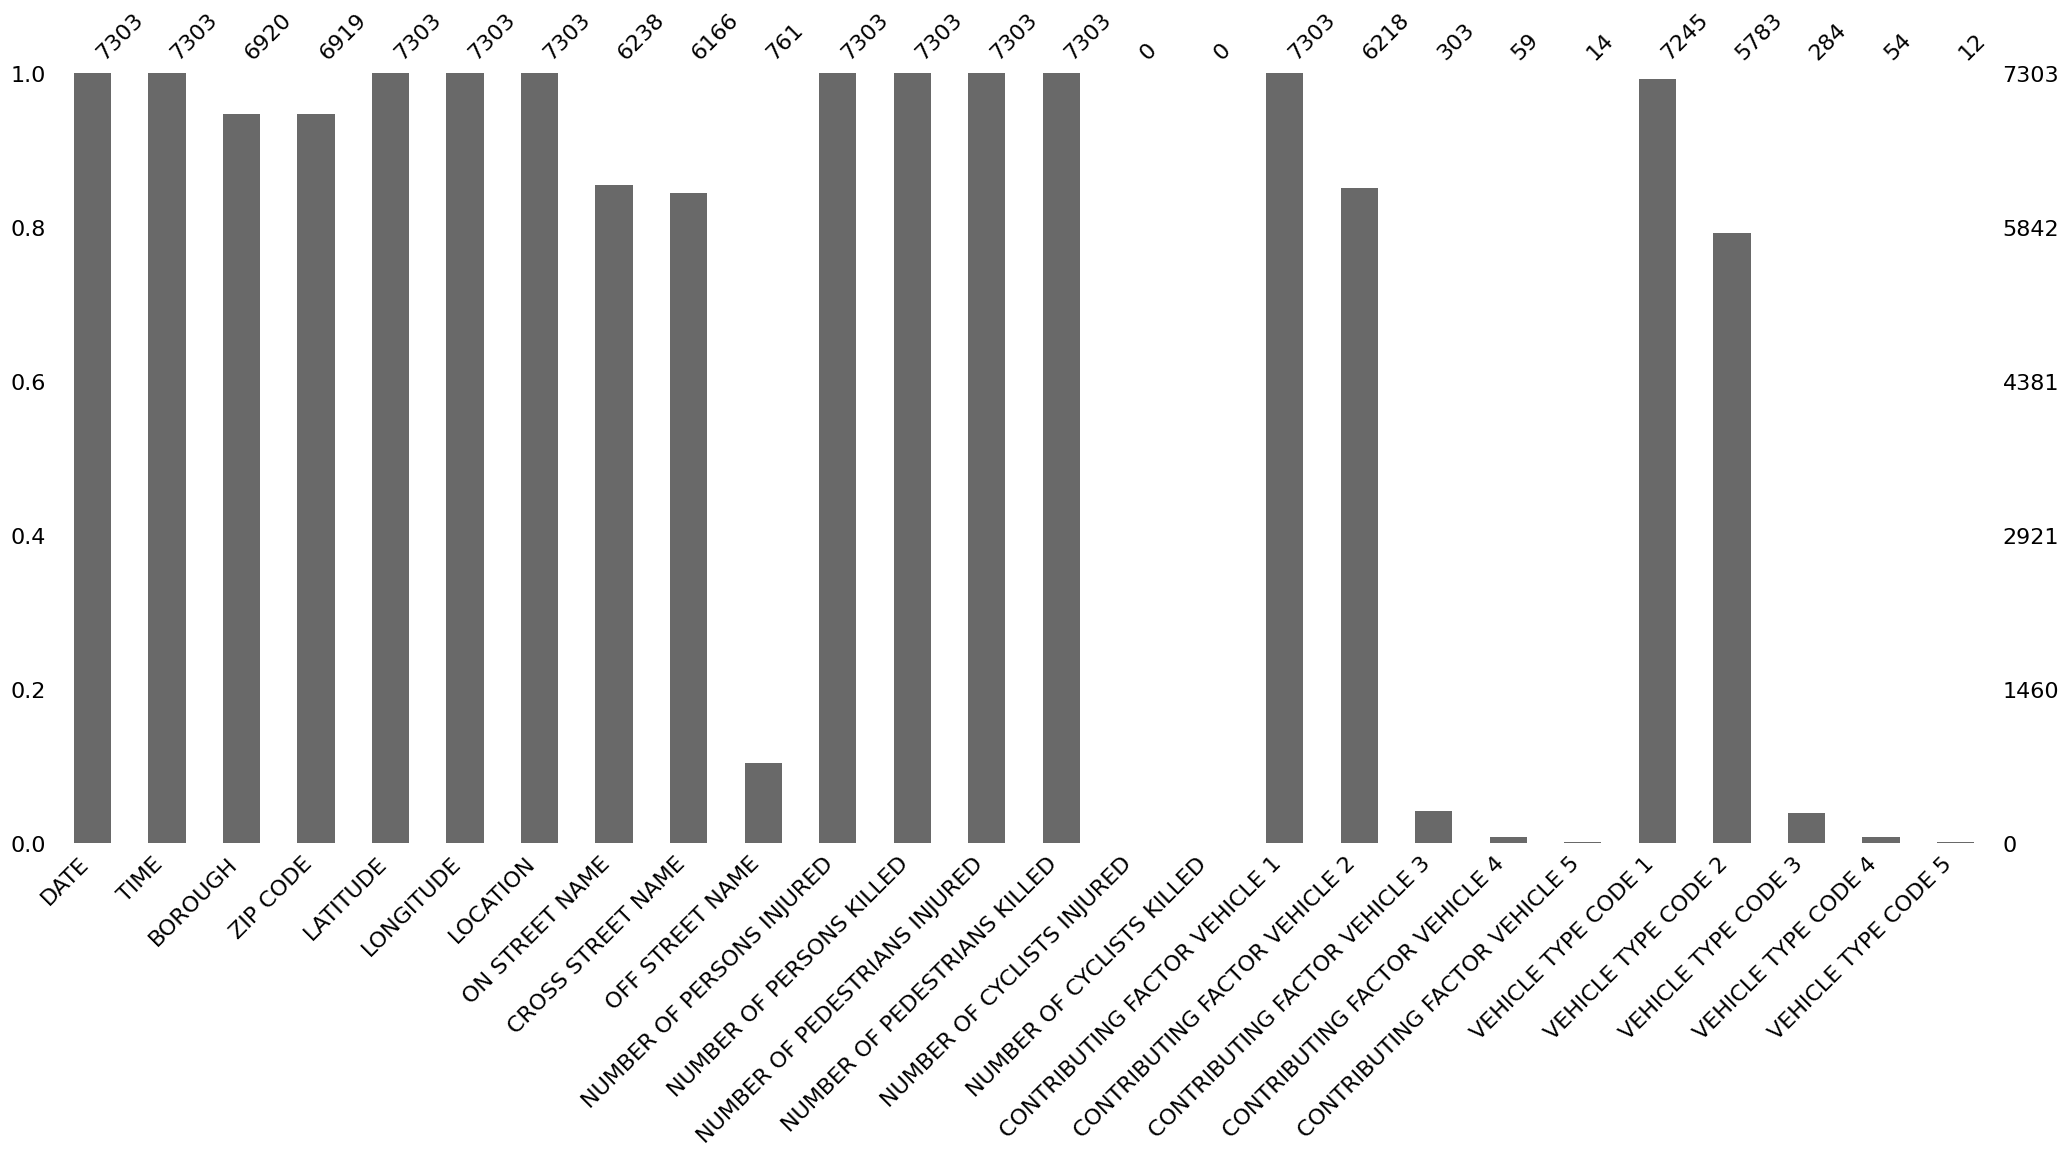

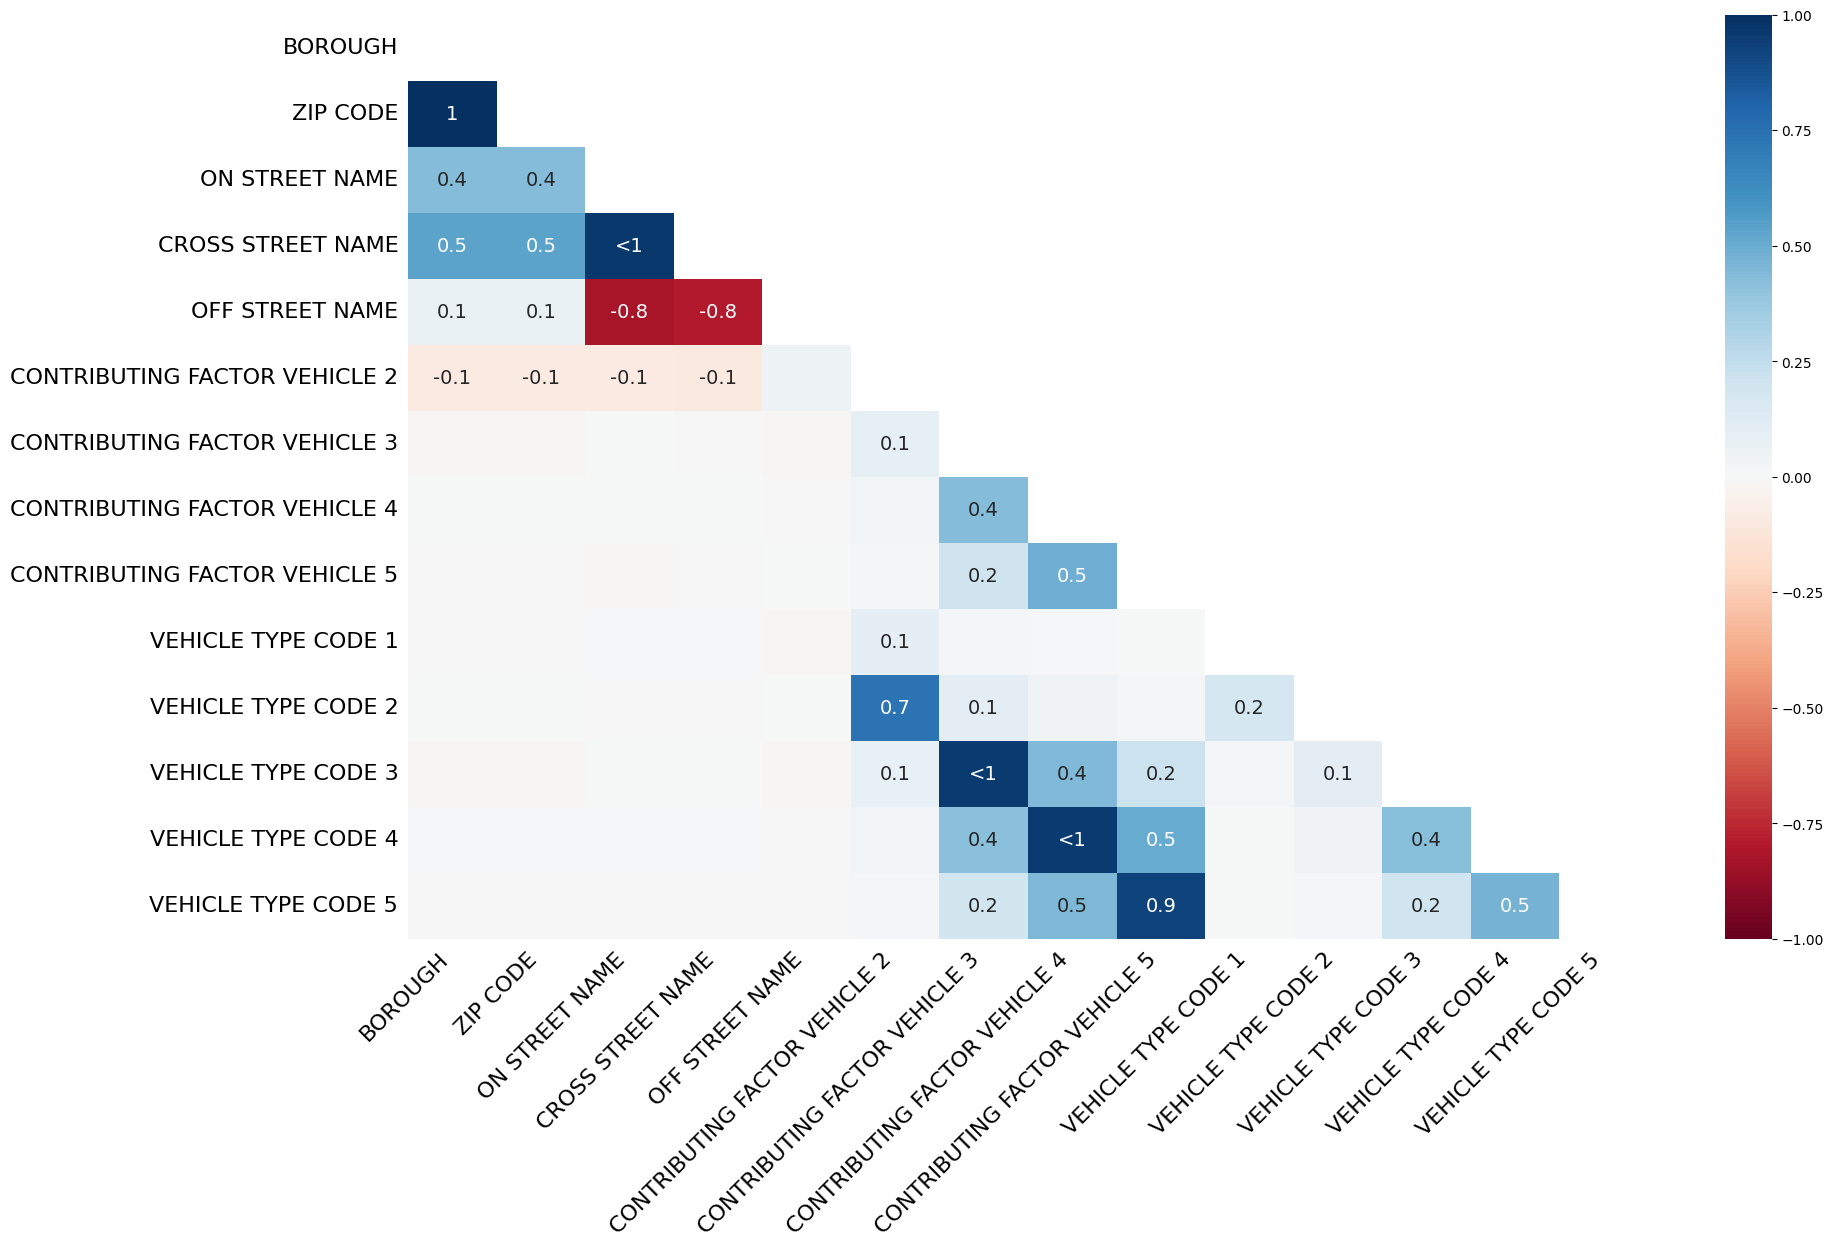

In [157]:
print(indicator_matrix_df.keys())
plt.show()
msno.matrix(indicator_matrix_df)
plt.savefig('figure/msno_matrix.png', format = 'png', dpi = 600)

plt.show()
msno.bar(indicator_matrix_df)
plt.savefig('figure/msno_bar.png', format = 'png', dpi = 600)

plt.show()
msno.heatmap(indicator_matrix_df)
plt.savefig('figure/msno_heatmap.png', format = 'png', dpi = 600)


### 1.3. Preprocess features <a class="anchor" id="section_1_2"></a> 

#### If needed

In [ ]:
indicator_matrix_df['male'] = indicator_matrix_df['gender'] != 'M'
indicator_matrix_df['male'] = indicator_matrix_df['male'].replace(True, math.nan)
indicator_matrix_df['female'] = indicator_matrix_df['gender'] == 'M'
indicator_matrix_df['female'] = indicator_matrix_df['female'].replace(True, math.nan)


indicator_matrix_df['prostate'] = indicator_matrix_df['indication'] != 'Prostate'
indicator_matrix_df['prostate'] = indicator_matrix_df['prostate'].replace(True, math.nan)
indicator_matrix_df['ovarian'] = indicator_matrix_df['indication'] != 'Ovarian'
indicator_matrix_df['ovarian'] = indicator_matrix_df['ovarian'].replace(True, math.nan)
indicator_matrix_df['breast'] = indicator_matrix_df['indication'] != 'Breast'
indicator_matrix_df['breast'] = indicator_matrix_df['breast'].replace(True, math.nan)                    
indicator_matrix_df['pancreatic'] = indicator_matrix_df['indication'] != 'Pancreatic'
indicator_matrix_df['pancreatic'] = indicator_matrix_df['pancreatic'].replace(True, math.nan)                    
                    
indicator_matrix_df = indicator_matrix_df.drop(columns = 'gender')
indicator_matrix_df = indicator_matrix_df.drop(columns = 'indication')

### 1.4. Create indicator matrix <a class="anchor" id="section_1_3"></a> 

missingness_ratio:  0.36798365266118244


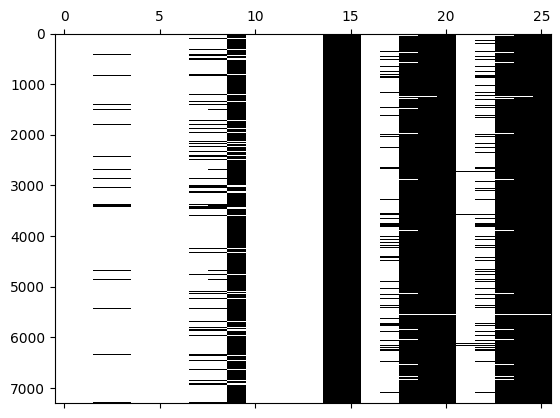

In [158]:
indicator_matrix_df = indicator_matrix_df.isna().replace(False, 0)
indicator_matrix_df = indicator_matrix_df.replace(True, 1)
indicator_matrix = np.array(indicator_matrix_df)

plt.matshow(indicator_matrix, fignum = 0, aspect = 'auto', cmap = 'binary')
plt.savefig('figure/indicator_matrix.png', format = 'png', dpi = 600)

missingness_ratio = np.count_nonzero(indicator_matrix)/(indicator_matrix.shape[0]*indicator_matrix.shape[1])
print("missingness_ratio: ", missingness_ratio)

In [15]:
# If no data was loaded, we can simulate an indicator matrix
# Create a 50x50 indicator matrix filled with zeros
matrix_size = 50
indicator_matrix = np.zeros((matrix_size, matrix_size))

for k in range(2000):
    # Generate random row and column indices
    random_row = np.random.randint(0, matrix_size)
    random_col = np.random.randint(0, matrix_size)

    # Set the random element to 1
    indicator_matrix[random_row, random_col] = 1

# Print the indicator matrix
print(indicator_matrix)

[[1. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 1.]]


### 1.5. Preprocess indicator matrix <a class="anchor" id="section_1_4"></a> 

#### If needed

In [174]:
# We remove all the full zeros columns (always known features) and the full ones columns (always unknown features)
sub_indicator_matrix = indicator_matrix[:,np.where((np.sum(indicator_matrix, axis = 0) != 0) & (np.sum(indicator_matrix, axis = 0) != len(indicator_matrix)))[0]]
np.save('data/sub_indicator_matrix.npy', sub_indicator_matrix)
print(sub_indicator_matrix)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


### 1.6. Information about the features <a class="anchor" id="section_1_5"></a> 

In [159]:
# Creation of the dictionnary to save the feature names
def dict_features(indicator_matrix, indicator_matrix_df, key, name):
    nonzeros = np.where((np.sum(indicator_matrix, axis = 0) != 0) & (np.sum(indicator_matrix, axis = 0) != len(indicator_matrix)))[0]
    indicator_matrix_df_keys = np.array(list(indicator_matrix_df.keys()))
    missing_features_list = indicator_matrix_df_keys[nonzeros]
    file = open('data/dict_features_' + name + '.txt', 'w')
    missing_features_dict = dict()
    compt = 0
    for i in range(len(missing_features_list)) :
        if 'test' not in missing_features_list[i] :
            missing_features_dict[compt] = missing_features_list[i]
            file.write(str(compt) + '\t' + str(missing_features_list[i]) + '\n')
            compt += 1
        elif ('test' in missing_features_list[i]) and (key in missing_features_list[i]) :
            missing_features_dict[compt] = missing_features_list[i]
            file.write(str(compt) + '\t' + str(missing_features_list[i]) + '\n')
            compt += 1
    file.close()
    return missing_features_dict

features_dict = dict_features(indicator_matrix, indicator_matrix_df, '', 'new')

## 2. Matrices construction <a class="anchor" id="section_2"></a>

### 2.1. Correlation matrix <a class="anchor" id="section_2_1"></a>

In [160]:
features_dict

{0: 'BOROUGH',
 1: 'ZIP CODE',
 2: 'ON STREET NAME',
 3: 'CROSS STREET NAME',
 4: 'OFF STREET NAME',
 5: 'CONTRIBUTING FACTOR VEHICLE 2',
 6: 'CONTRIBUTING FACTOR VEHICLE 3',
 7: 'CONTRIBUTING FACTOR VEHICLE 4',
 8: 'CONTRIBUTING FACTOR VEHICLE 5',
 9: 'VEHICLE TYPE CODE 1',
 10: 'VEHICLE TYPE CODE 2',
 11: 'VEHICLE TYPE CODE 3',
 12: 'VEHICLE TYPE CODE 4',
 13: 'VEHICLE TYPE CODE 5'}

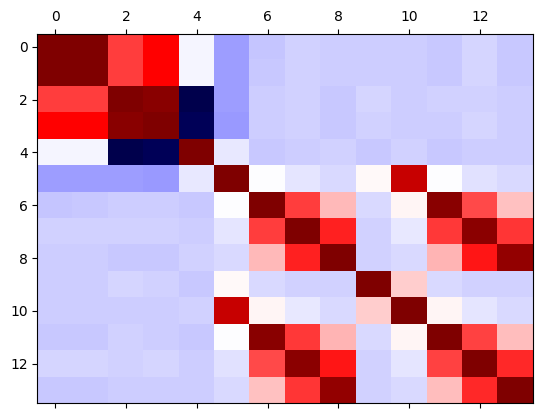

In [161]:
def create_corr(indicator, savefig = True):
    Corr = np.corrcoef(indicator.T)
    if savefig == True:
        plt.matshow(Corr, fignum=0, aspect='auto', cmap = 'seismic')
        plt.savefig('figure/corr_matrix.png', format = 'png', dpi = 600)
        np.save('data/Corr_matrix.npy', Corr)
    return Corr

Corr_matrix = create_corr(sub_indicator_matrix)

### 2.2. Distance matrix <a class="anchor" id="section_2_2"></a>

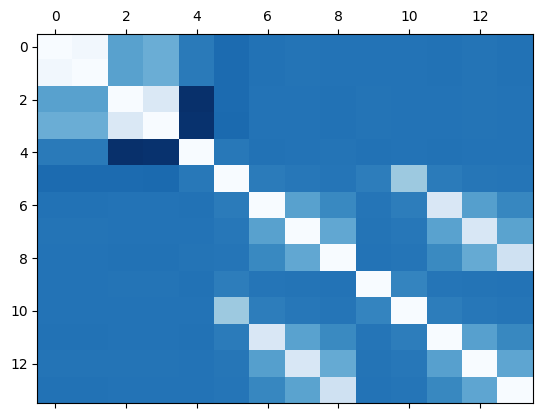

In [162]:
def create_distance(Corr, savefig = True):
    Distance = np.sqrt(2*(1-Corr))
    if savefig == True:
        plt.matshow(Distance, fignum=0, aspect='auto', cmap = 'Blues')
        plt.savefig('figure/Distance_matrix.png', format = 'png', dpi = 600)
        np.save('data/Distance_matrix.npy', Distance)
    return Distance

Distance_matrix = create_distance(Corr_matrix)

### 2.3. Mutual information matrix <a class="anchor" id="section_2_3"></a>

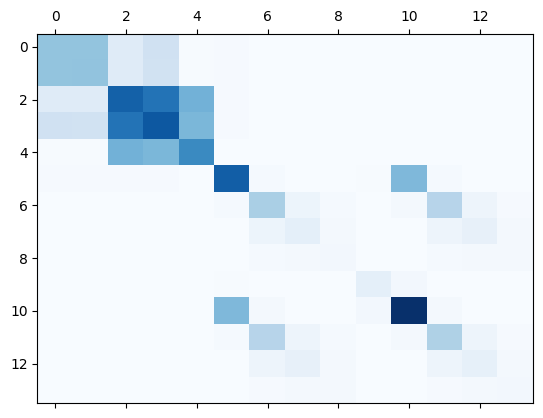

In [163]:
def create_MI(indicator, savefig = True):
    MI = drv.information_mutual(indicator.T)
    if savefig == True:
        plt.matshow(MI, fignum=0, aspect='auto', cmap = 'Blues')
        plt.savefig('figure/MI_matrix.png', format = 'png', dpi = 600)
        np.save('data/MI_matrix.npy', MI)
    return MI

MI_matrix = create_MI(sub_indicator_matrix)

## 3. Networks construction <a class="anchor" id="section_3"></a>

### 3.1. Maximum Spanning Tree (MST): graph <a class="anchor" id="section_3_1"></a>

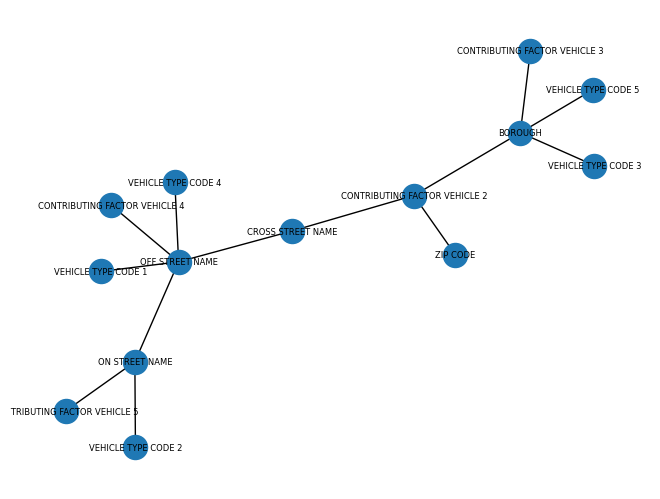

In [173]:
def create_mst(matrix, missing_features_dict = None, savegraph = True):
    graph = nx.from_numpy_array(matrix)
    if missing_features_dict != None:
        graph = nx.relabel_nodes(graph, missing_features_dict)
    graph = nx.maximum_spanning_tree(graph)
    if savegraph == True:
        nx.write_edgelist(graph, 'data/A_MST.txt', delimiter = '\t')
    return nx.adjacency_matrix(graph), graph

mst_A, mst_graph = create_mst(Distance_matrix, features_dict)
nx.draw(mst_graph, with_labels = True, font_size = 6)

### 3.2. Planar Maximally Filtered Graph (PMFG): graph <a class="anchor" id="section_3_2"></a>

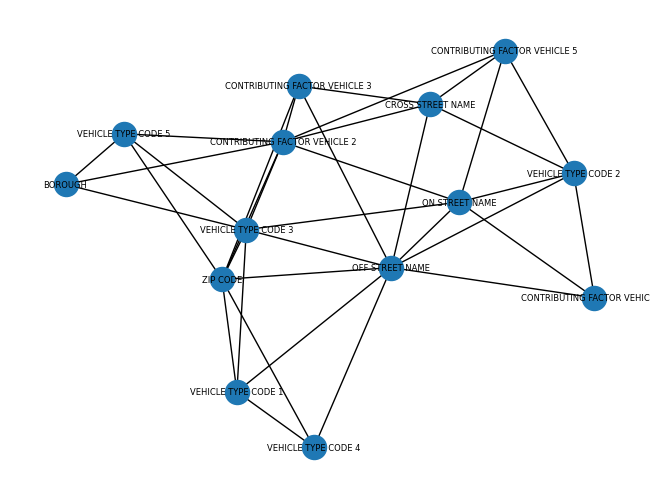

In [172]:
def create_pmfg(matrix, missing_features_dict = None, savegraph = True):
    matrix_pmfg = pmfg(matrix)
    graph = nx.from_numpy_array(matrix_pmfg)
    if missing_features_dict != None:
        graph = nx.relabel_nodes(graph, missing_features_dict)
    if savegraph == True:
        nx.write_edgelist(graph, 'data/A_PMFG.txt', delimiter = '\t')
    return matrix_pmfg, graph

pmfg_A, pmfg_graph = create_pmfg(Distance_matrix, features_dict)
nx.draw(pmfg_graph, with_labels = True, font_size = 6)

### 3.3. Disparity Filter (Backbone): graph <a class="anchor" id="section_3_3"></a>

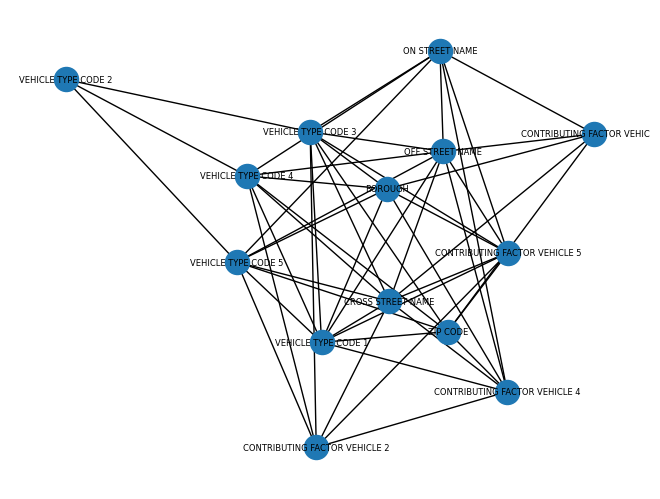

In [171]:
def create_backbone(matrix, alpha = 0.35, missing_features_dict = None, savegraph = True):
    if np.any(matrix < 0):
        matrix[matrix < 0] = 0
    np.diag(matrix, 0)
    graph_matrix = nx.from_numpy_array(matrix)

    B_graph = disparity_filter(graph_matrix)
    graph = disparity_filter_alpha_cut(B_graph, alpha_t = alpha)
    if missing_features_dict != None:
        graph = nx.relabel_nodes(graph, missing_features_dict)
    if savegraph == True:
        nx.write_edgelist(graph, 'data/A_backbone_' + str(alpha) + '.txt', delimiter = '\t')
    return nx.adjacency_matrix(graph), graph

backbone_A, backbone_graph = create_backbone(Distance_matrix, missing_features_dict = features_dict)
nx.draw(backbone_graph, with_labels = True, font_size = 6)

### 3.4. Efficiency Cost Optimisation (ECO): graph <a class="anchor" id="section_3_4"></a>

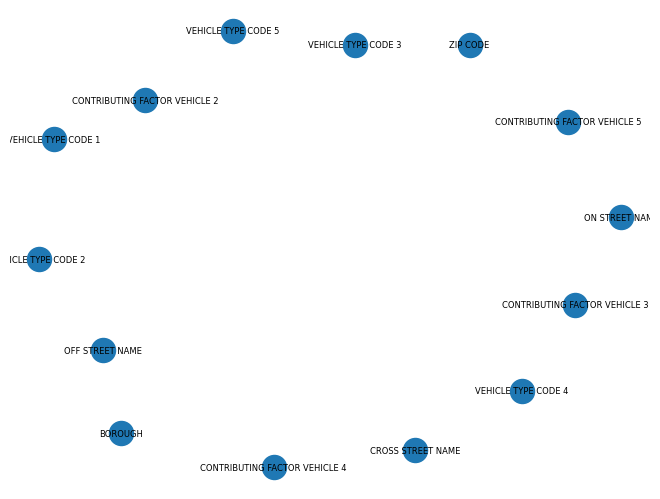

In [169]:
def create_eco(matrix, missing_features_dict = None, savegraph = True):
    matrix_eco = eco(matrix)
    graph = nx.from_numpy_array(matrix_eco)
    if missing_features_dict != None:
        graph = nx.relabel_nodes(graph, missing_features_dict)
    if savegraph == True:
        nx.write_edgelist(graph, 'data/A_ECO.txt', delimiter = '\t')
    return matrix_eco, graph

eco_A, eco_graph = create_eco(Distance_matrix, features_dict)
nx.draw(eco_graph, with_labels = True, font_size = 6)

### 3.5. Triangulated Maximally Filtered Graph (TMFG): Simplificial complex <a class="anchor" id="section_3_5"></a>

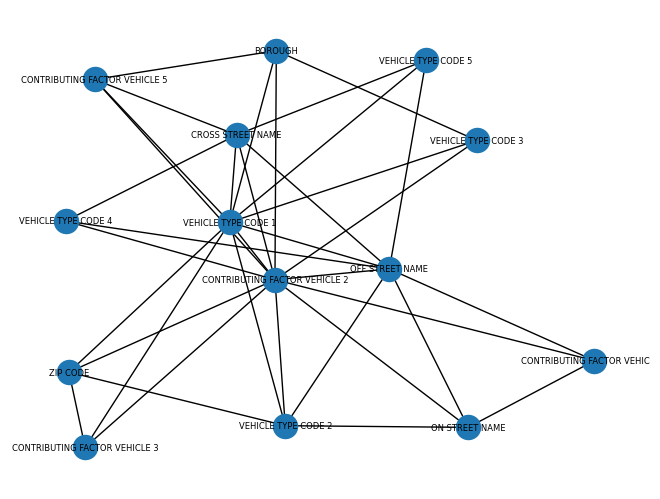

In [170]:
def create_tmfg(matrix, missing_features_dict = None, savegraph = True):
    graph = tmfg(matrix)
    if missing_features_dict != None:
        graph = nx.relabel_nodes(graph, missing_features_dict)
    if savegraph == True:
        nx.write_edgelist(graph, 'data/A_TMFG.txt', delimiter = '\t')
    return nx.adjacency_matrix(graph), graph

tmfg_A, tmfg_graph = create_tmfg(Distance_matrix, features_dict)
nx.draw(tmfg_graph, with_labels = True, font_size = 6)